In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# 替换为您的实际Excel文件路径
file_path = "./CCCV3.0 1-2000.xlsx"

# 创建一个空字典来储存所有工作表的D列和E列数据
sheets_data = {}

cycle_num = 0

# 使用pandas读取Excel文件
with pd.ExcelFile(file_path) as xls:
    for sheet_name in xls.sheet_names:
        df = pd.read_excel(xls, sheet_name=sheet_name)
        columns_data = df.iloc[0:, [3]]
        sheets_data[sheet_name] = columns_data


for key in sheets_data:
    df = sheets_data[key]
    col = df["放电容量(Ah)"]
    
    result = []
    for cell in col:
        result.append(cell)
    sheets_data[key] = result
    
    print(f'key: {key}, cnt: {len(result)}')


key: Cycle, cnt: 921


In [24]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial

def poly_fit(x, y, order):
    coef = np.polyfit(x, y, order)
    poly = Polynomial(coef[::-1])  # np.polyfit的系数是从高次到低次，Polynomial需要从低次到高次
    return poly

In [20]:
def get_80pct_cycle(capacity):
    cnt = 0
    for i in range(len(capacity)):
        if capacity[i] / capacity[0] < 0.8:
            if cnt == 0:
                return i, capacity[i]
            cnt += 1
            if cnt == 5:
                break
        else:
            cnt == 0

In [21]:
def plot_poly(poly, x, y):
    plt.figure()
    y_fit = poly(x)
    plt.plot(x, y, 'ro', label='Original data')
    plt.plot(x, y_fit, 'b-', label='Fitted curve')
    plt.plot(*get_80pct_cycle(y), 'go', label='80% capacity')
    plt.title('Battery Capacity Degradation')
    plt.xlabel('Cycle')
    plt.ylabel('Capacity (Ah)')
    plt.legend()
    plt.grid(True)
    plt.show()

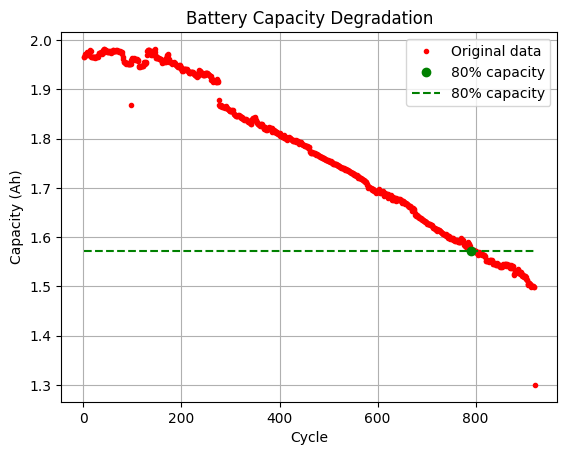

In [27]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default') # 或使用其他样式，例如 'ggplot', 'seaborn-dark' 等

capacity = sheets_data['Cycle']
cycle = np.arange(1, len(capacity)+1)

plt.figure()
plt.plot(cycle, capacity, 'ro', label='Original data', markersize=3)
p_x, p_y = get_80pct_cycle(capacity) 
plt.plot(p_x, p_y, 'go', label='80% capacity')
plt.plot(cycle, [p_y for _ in range(len(cycle))], 'g--', label='80% capacity')
plt.title('Battery Capacity Degradation')
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
plt.legend()
plt.grid(True)
plt.show()

模型评估


In [5]:
import numpy as np

# 计算MSE
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# 计算R²
def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ss_res / ss_tot)

Order: 1
MSE: 0.00038051607334768894
R²: 0.9834009124172244


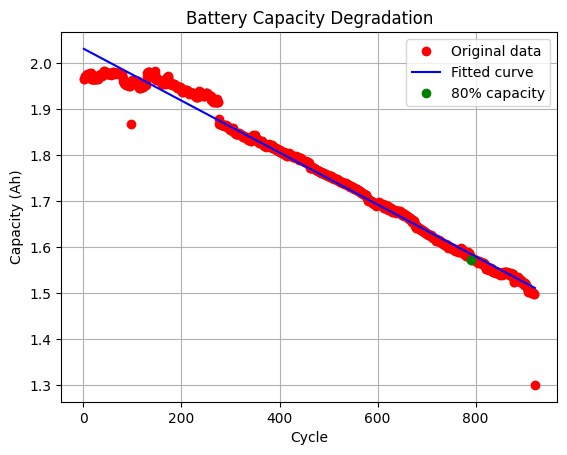

Order: 2
MSE: 0.00027394549696491686
R²: 0.9880497944356934


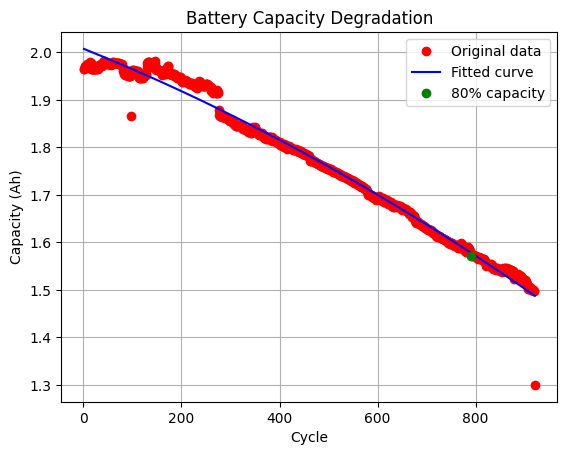

Order: 3
MSE: 0.00020753714679557365
R²: 0.9909466970842219


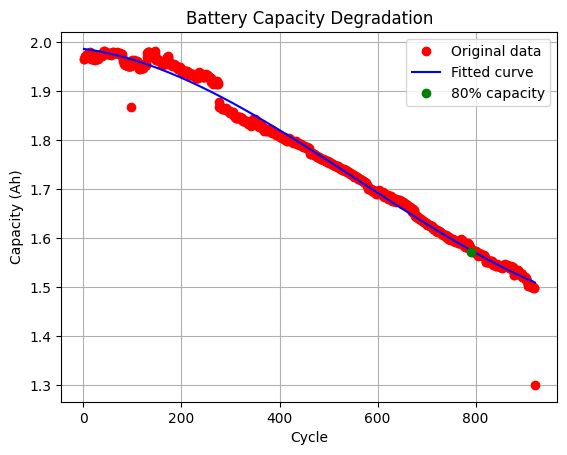

Order: 4
MSE: 0.00016625857847897346
R²: 0.99274737416141


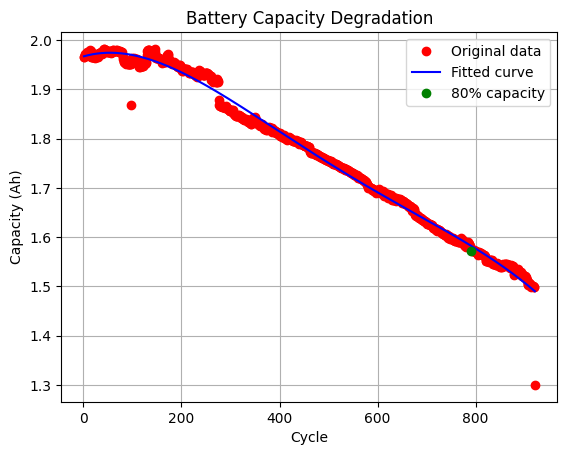

Order: 5
MSE: 0.0001566091589436316
R²: 0.993168306603451


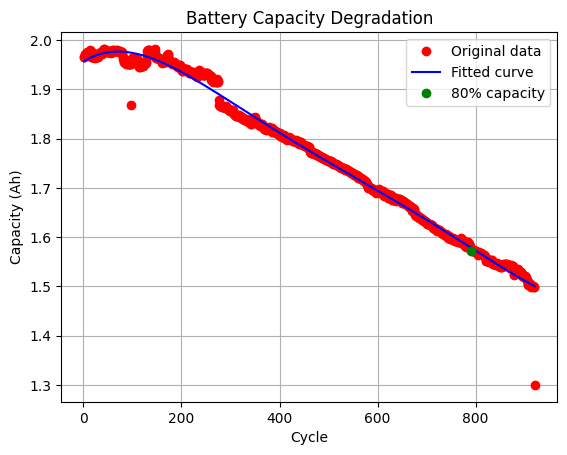

Order: 6
MSE: 0.00015546313925790043
R²: 0.9932182989230071


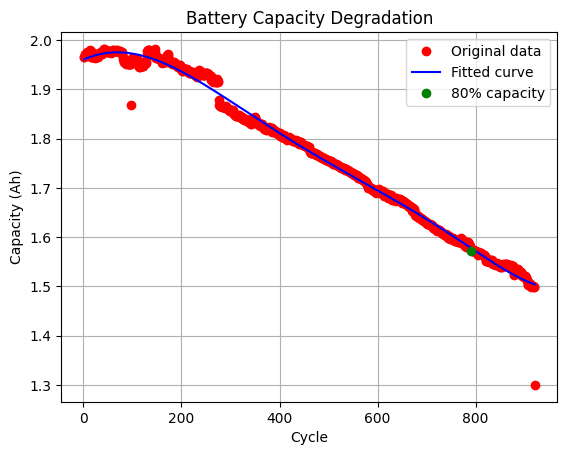

MSE: [0.00038051607334768894, 0.00027394549696491686, 0.00020753714679557365, 0.00016625857847897346, 0.0001566091589436316, 0.00015546313925790043]
6 0.00015546313925790043


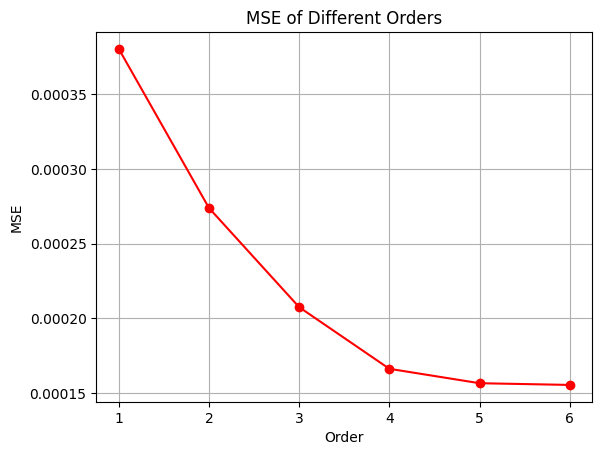

R²: [0.9834009124172244, 0.9880497944356934, 0.9909466970842219, 0.99274737416141, 0.993168306603451, 0.9932182989230071]
6 0.9932182989230071


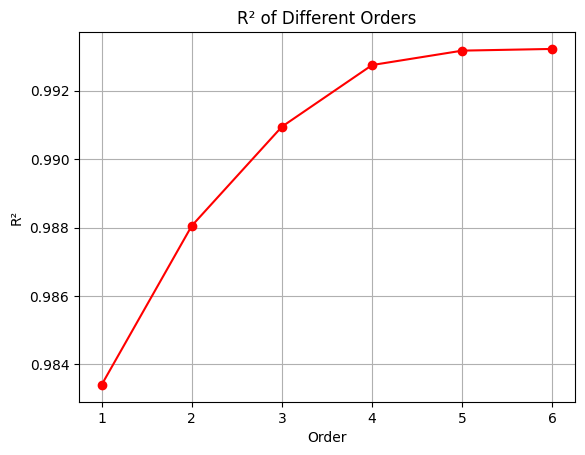

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

plt.style.use('default') # 或使用其他样式，例如 'ggplot', 'seaborn-dark' 等

capacity = sheets_data['Cycle']
cycle = np.arange(1, len(capacity)+1)

mse_list = []
r2_list = []

MAX_ORDER = 6
for order in range(1, MAX_ORDER+1):
    print(f'Order: {order}')
    
    poly = poly_fit(cycle, capacity, order)
        
    _ = mse(capacity, poly(cycle))
    mse_list.append(_)
    print(f'MSE: {_}')
    
    _ = r2(capacity, poly(cycle))
    r2_list.append(_)
    print(f'R²: {_}')
    
    plot_poly(poly, cycle, capacity)

print(f"MSE: {mse_list}")
print(mse_list.index(min(mse_list)) + 1, min(mse_list))

plt.figure()
plt.plot(range(1, MAX_ORDER+1), mse_list, 'ro-')
plt.title('MSE of Different Orders')
plt.xlabel('Order')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

print(f"R²: {r2_list}")
print(r2_list.index(max(r2_list)) + 1, max(r2_list))
plt.figure()
plt.plot(range(1, MAX_ORDER+1), r2_list, 'ro-')
plt.title('R² of Different Orders')
plt.xlabel('Order')
plt.ylabel('R²')
plt.grid(True)
plt.show()

现在我截取一段数据（长度称之为最小长度 l0）进行训练，拟合出一个多项式形式的回归函数，并通过该函数估计 RUL。

然后增加 10 个数据，重新训练，重新估计 RUL。

重复上述过程，直到数据集的长度达到最大长度 l。

该过程中，RUL 的标签值是已知的，因此可以通过计算预测值与标签值的差值，来评估模型的性能。


In [7]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial

def fit_partial(y, l, r, order):
    y = y[l:r]
    x = np.arange(l, r)
    coef = np.polyfit(x, y, order)
    poly = Polynomial(coef[::-1])
    return poly

def pred_80pct_cycle(poly, initial_capacity):
    coef = poly.coef
    beta_0, beta_1 = coef
    # print(f'intial capacity: {initial_capacity}')
    # print(f'β₀: {beta_0}, β₁: {beta_1}')
    # print(f'80% capacity cycle: {(0.8 * initial_capacity - beta_0) / beta_1}')
    return (0.8 * initial_capacity - beta_0) / beta_1, 0.8 * initial_capacity

In [8]:
def plot_poly_pred(poly, x, y):
    plt.figure(figsize=(7, 3))
    y_fit = poly(x)
    plt.plot(x, y, 'ro', label='Original data')
    plt.plot(x, y_fit, 'b-', label='Fitted curve')
    plt.plot(*get_80pct_cycle(y), 'go', label='80% capacity')
    # if pred_80pct_cycle(poly, y[0]) is not None:
    plt.plot(*pred_80pct_cycle(poly, y[0]), 'bo', label='Predicted 80% capacity')
    plt.title('Battery Capacity Degradation')
    plt.xlabel('Cycle')
    plt.ylabel('Capacity (Ah)')
    plt.legend()
    plt.grid(True)
    plt.show()

Partial fit with (0, 100)
80% capacity: true: 791, pred: 2403.368943170388, diff: 1612.3689431703879


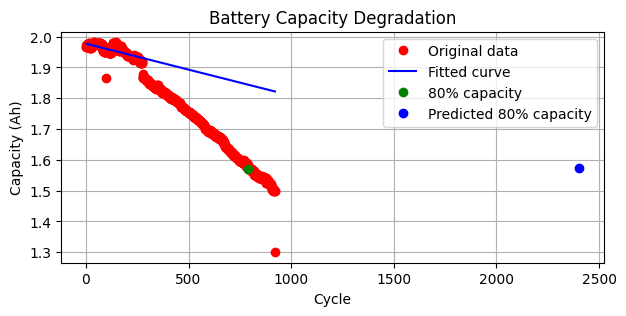

Partial fit with (50, 150)
80% capacity: true: 791, pred: 4143.474937940627, diff: 3352.4749379406267


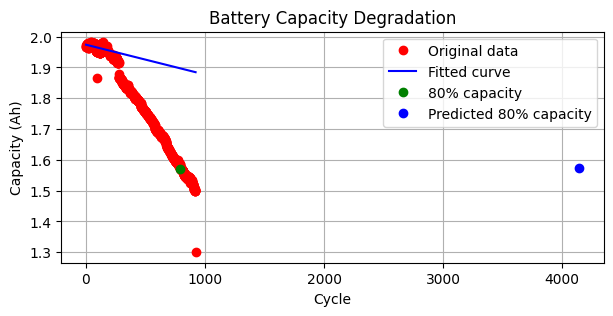

Partial fit with (100, 200)
80% capacity: true: 791, pred: 4088.50648167963, diff: 3297.50648167963


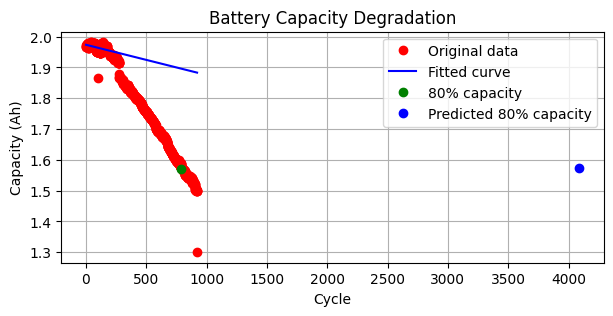

Partial fit with (150, 250)
80% capacity: true: 791, pred: 1147.3526671186576, diff: 356.35266711865756


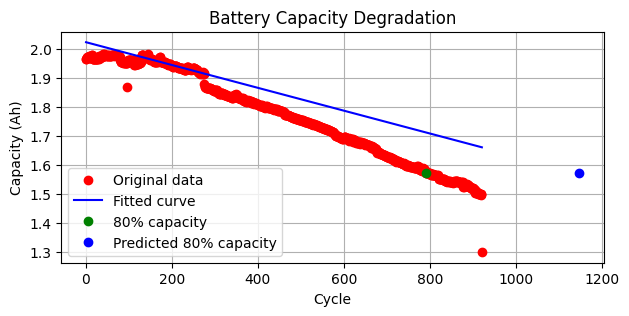

Partial fit with (200, 300)
80% capacity: true: 791, pred: 633.5513144482917, diff: 157.4486855517083


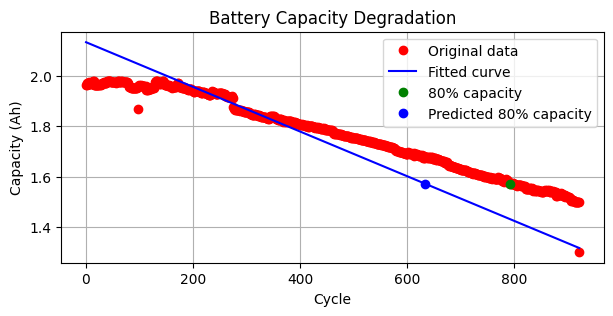

Partial fit with (250, 350)
80% capacity: true: 791, pred: 581.5765063867733, diff: 209.4234936132267


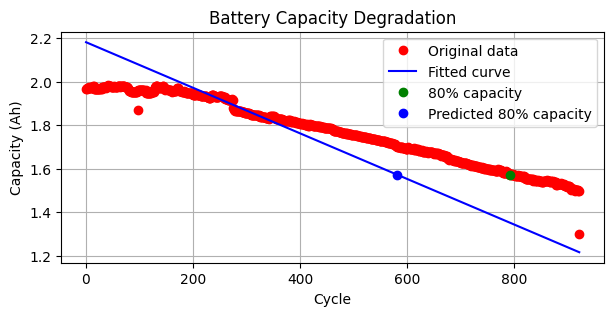

Partial fit with (300, 400)
80% capacity: true: 791, pred: 947.8990968726346, diff: 156.89909687263457


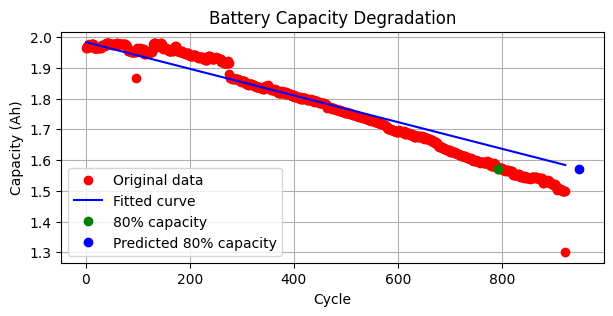

Partial fit with (350, 450)
80% capacity: true: 791, pred: 901.5737943598948, diff: 110.5737943598948


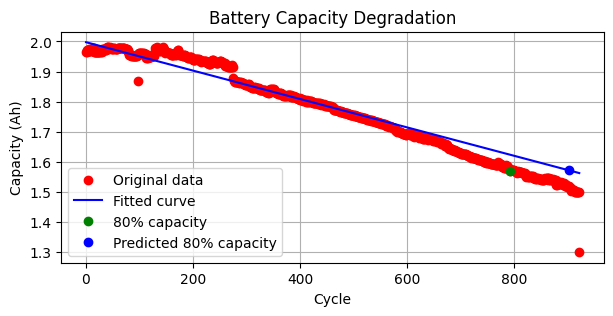

Partial fit with (400, 500)
80% capacity: true: 791, pred: 825.1181306256939, diff: 34.11813062569388


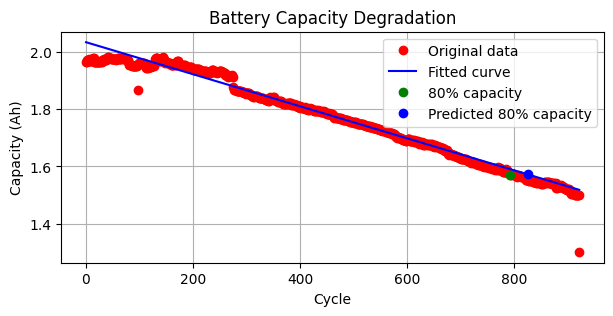

Partial fit with (450, 550)
80% capacity: true: 791, pred: 830.526326927272, diff: 39.52632692727195


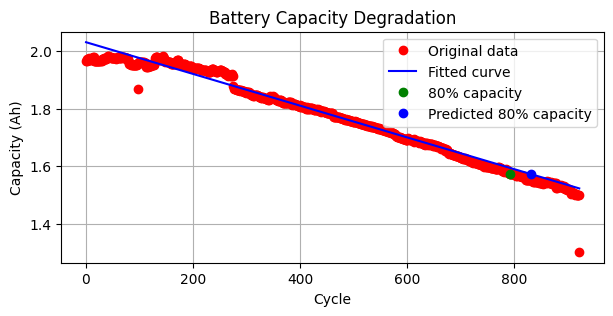

Partial fit with (500, 600)
80% capacity: true: 791, pred: 784.5587438433828, diff: 6.441256156617214


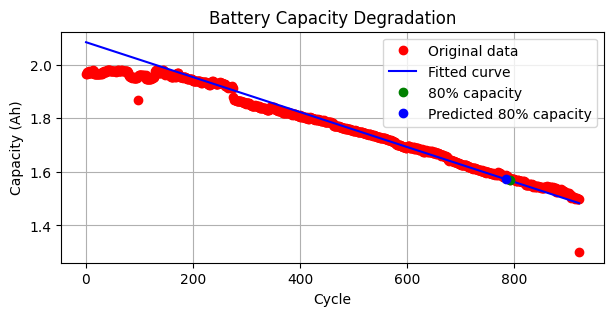

Partial fit with (550, 650)
80% capacity: true: 791, pred: 819.0404152522303, diff: 28.040415252230332


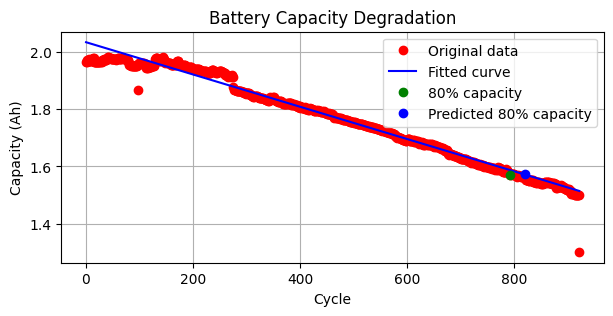

Partial fit with (600, 700)
80% capacity: true: 791, pred: 793.0379429424911, diff: 2.0379429424910995


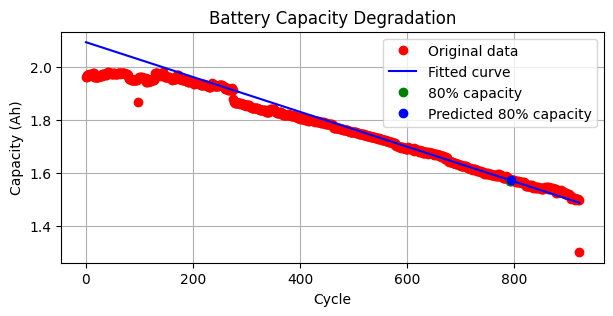

Partial fit with (650, 750)
80% capacity: true: 791, pred: 776.6405556597522, diff: 14.35944434024782


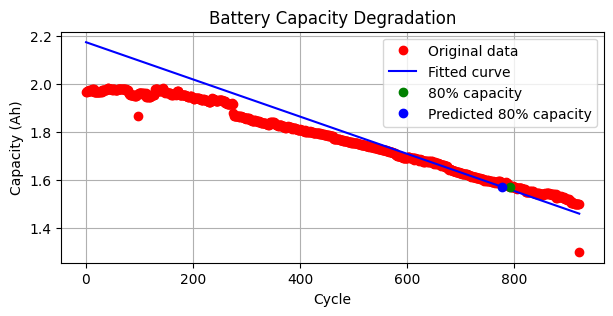

Partial fit with (700, 800)
80% capacity: true: 791, pred: 799.164323068236, diff: 8.164323068235944


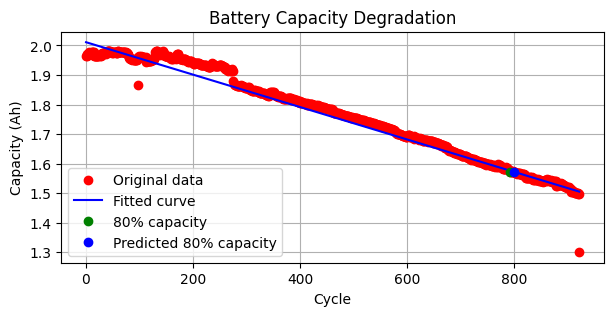

Partial fit with (750, 850)
80% capacity: true: 791, pred: 796.7763721952862, diff: 5.7763721952861715


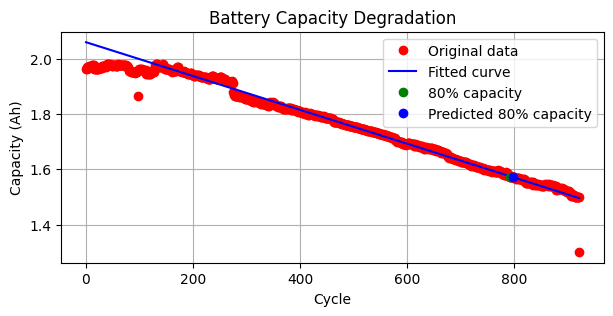

Partial fit with (800, 900)
80% capacity: true: 791, pred: 788.0925180191014, diff: 2.9074819808986376


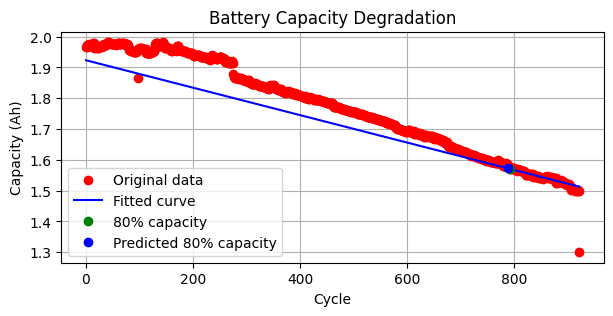

In [9]:
l = 0
r = 100
ORDER = 1
delta_l = 50

while r < len(capacity):
    poly = fit_partial(capacity, l, r, ORDER)
    print(f'Partial fit with ({l}, {r})')
    idx_true, cycle_true = get_80pct_cycle(capacity)
    idx_pred, cycle_pred = pred_80pct_cycle(poly, capacity[0])
    print(f'80% capacity: true: {idx_true}, pred: {idx_pred}, diff: {abs(idx_true-idx_pred)}')
    plot_poly_pred(poly, cycle, capacity)
    l += delta_l
    r += delta_l


神经网络模型

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# 单特征输入
input_dim = 1

model_mlp = Sequential([
    Dense(64, input_dim=input_dim, activation='relu'),  # 第一隐藏层
    Dense(32, activation='relu'),  # 第二隐藏层
    Dense(1, activation='linear')  # 输出层，线性激活函数用于回归问题
])

model_mlp.compile(optimizer='adam', loss='mean_squared_error')


In [13]:
import torch
from torch import nn

class LSTMNet(nn.Module):
    def __init__(self):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, batch_first=True)  # 假设输入特征只有1维
        self.fc = nn.Linear(64, 1)  # 假设我们做的是回归任务
    
    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (h_n, _) = self.lstm(x)
        x = h_n[-1, :, :]
        return self.fc(x)


In [38]:
from torch import optim

L = 0
R = 800

model = LSTMNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 假设你已经有了训练数据X_train和y_train
# 注意：在训练之前，你需要将数据转换为Tensor

X_train = torch.tensor(cycle[L:R]).float().unsqueeze(-1).unsqueeze(-1)  # 增加两个维度
# 现在X_train的形状应该是 [batch_size, seq_len, features]，其中seq_len=1, features=1
y_train = torch.tensor(capacity[L:R]).float().unsqueeze(-1)  # 确保y_train也有正确的维度


# 训练模型（示例）
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 4.116542339324951
Epoch 101, Loss: 0.017852412536740303
Epoch 201, Loss: 0.0052198306657373905
Epoch 301, Loss: 0.0022059394977986813
Epoch 401, Loss: 0.0011494491482153535
Epoch 501, Loss: 0.000687076011672616
Epoch 601, Loss: 0.00045963324373587966
Epoch 701, Loss: 0.0003594931913539767
Epoch 801, Loss: 0.00027285516262054443
Epoch 901, Loss: 0.00024052165099419653


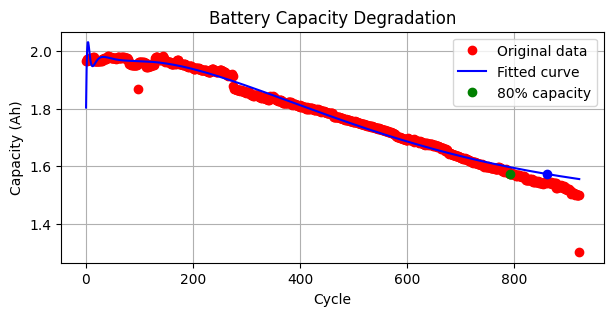

80% capacity cycle: 861, true: 791, diff: 70


In [39]:
y_pred = model(torch.tensor(cycle).float().unsqueeze(-1).unsqueeze(-1)).detach().numpy().flatten()
plt.figure(figsize=(7, 3))
plt.plot(cycle, capacity, 'ro', label='Original data')
plt.plot(cycle, y_pred, 'b-', label='Fitted curve')
plt.plot(*get_80pct_cycle(capacity), 'go', label='80% capacity')
for y in y_pred:
    if y < 0.8 * capacity[0]:
        plt.plot(cycle[y_pred == y], y_pred[y_pred == y], 'bo')
        target_cycle = cycle[y_pred == y][0]
        break
# plt.plot(*pred_80pct_cycle(poly, y[0]), 'bo', label='Predicted 80% capacity')
plt.title('Battery Capacity Degradation')
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
plt.legend()
plt.grid(True)
plt.show()

print(f'80% capacity cycle: {target_cycle}, true: {get_80pct_cycle(capacity)[0]}, diff: {abs(target_cycle-get_80pct_cycle(capacity)[0])}')